# Validation of the classification based on the WFsim #

2019/09/28

Authors:
 - Clark, Michael <clark632@purdue.edu>
 - Angevaare, Joran <j.angevaare@nikhef.nl>
 
**Updates:**

2019/11/14

## This notebook #
Buggs in the WFsim that are important to keep in mind:
 -  <s>There is no double photo-emission taken into account
 -  There may be only ~ 500 events before the WFsim crashes<s>
 
 
Possible extensions:
 - Add afterpulse boolian to the 'truth' info
 - Do the same for the other detector types

In [1]:
import strax
import straxen

In [2]:
import wfsim

We include ``recarray_tools.py`` here that is used to add columns and do things with structured arrays. 
Taken from:

    https://github.com/XENON1T/XeAnalysisScripts/tree/master/PeakFinderTest

In [3]:
from peak_classification.peak_finder import *

In [4]:
from peak_classification.wfsim_utils import *

Initize the wavefrom simulator

In [5]:
c = dict(event_rate = 50, chunk_size=1, nchunk=1)
inst = rand_instructions(c)
pd.DataFrame(inst).to_csv('test_uni.csv', index=False)

In [6]:
st = strax.Context(
register=[wfsim.RawRecordsFromFax],
config=dict(fax_file='./test_uni.csv'),
**straxen.contexts.common_opts)

In [7]:
# Just some id from post-SR1, so the corrections work
run_id = '180519_1902'

In [8]:
!rm -r strax_data
peaks = st.make(run_id, 'peak_basics')

Simulating Raw Records: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


Source finished!


In [9]:
truth = st.get_array(run_id, 'truth')
data = st.get_array(run_id, ['peak_basics','peak_classification'])

This is to compensate for the fact that we dont have event numbers (Binning in time to group peaks)

In [10]:
n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
c['total_time'] = c['chunk_size'] * c['nchunk']
timing_grid = np.linspace(0, c['total_time'], n+1) * 1e9

In [11]:
### Proxy for event number

truth = append_fields(truth, 'merge_index',np.digitize(truth['t'], timing_grid))
data = append_fields(data, 'merge_index',np.digitize(data['time'], timing_grid))

In [12]:
### Proxy for area of truth peak

truth = append_fields(truth, 'area', truth['n_photon'])

**There is a bug that the types are listed here as strings, where in strax they are integers**
The code here is to change that such that we can compare them directly

In [13]:
###!! 
###!! 
###!!
###!!

truth = append_fields(truth, 'typeint',np.ones(len(truth)), dtypes=np.int)
# truth['typeint'][truth['type'] == 's2'] = np.int(2)
# truth['typeint'][truth['type'] == 's1'] = np.int(1)
data = append_fields(data, 'typeint',data['type'], dtypes=np.int)


Proxy for ``left`` and ``right`` (as in ``PAX``) sides of peak in truth.

In [14]:
### Proxy for left and right of peak
truth = append_fields(truth, 
                      ('time','endtime'), 
                      (truth['t_first_photon'],
                       truth['t_last_photon']))

##3 Will need to add check to see if last electron is after last photon as below
#
#truth['endtime'] = truth['t_last_photon']
#mask = truth['endtime'] < truth['t_last_electron']
#truth['endtime'][mask] = truth['t_last_electron'][mask]

**We think there is a bug that makes all the peak times 500 ns earlier than the truth values**

We change the data here to move all times by 500 ns

In [15]:
###!!
###!!
###!! 
# data['time'] = data['time']+500
# data['endtime'] = data['endtime']+500

Here in match_peaks.py, written by Jelle, to compare two sets of peaks

Changes:
  -  Changed 'type' to 'typeint' because types are listed as integers in strax

Call with (truth, data)

In [16]:
truthmatched, datamatched = match_peaks(truth,data)

Matching peaks: 100%|██████████| 50/50 [00:00<00:00, 1041.87it/s]

	Appending extra fields...

	Grouping peaks 1 by event...

	Grouping peaks 2 by event...



Below is the output of match_peaks for the truth data.  
  - For each peak, **outcome** shows whether the peak was found, missed, merged, split up, or misidentified in the output of strax for the simulated data
  - **matched_to** shows which peak (peak_id in the other array) it was matched with, or the biggest peak it was matched with 

<img src='toptruthmatches.png'>
  
Below is the corresponding match_index in the simulated data
<img src='topdatamatch.png'>
  
You can see the splitting of the true s2 into an s1 and an s2

In [17]:
pd.DataFrame.from_records(truthmatched[['merge_index','type','time','area','endtime','matched_to','outcome']])


,merge_index,type,time,area,endtime,matched_to,outcome
0,1,1,1.000001e+07,247.0,1.000019e+07,0,b'found'
1,1,2,1.064404e+07,174.0,1.064822e+07,2,b'split_and_misid'
2,2,1,3.000002e+07,52.0,3.000015e+07,3,b'found'
3,2,2,3.050432e+07,214.0,3.050685e+07,4,b'misid_as_s2'
4,3,1,5.000001e+07,211.0,5.000020e+07,6,b'found'
...,...,...,...,...,...,...,...
95,48,2,9.504295e+08,16995.0,9.504384e+08,286,b'misid_as_s2'
96,49,1,9.700000e+08,111.0,9.700002e+08,292,b'found'
97,49,2,9.706518e+08,508.0,9.706568e+08,293,b'misid_as_s2'
98,50,1,9.900000e+08,311.0,9.900002e+08,294,b'found'


In [18]:
pd.DataFrame.from_records(datamatched[['merge_index','type','time','area','endtime','matched_to','outcome']]).head(20)
#pd.DataFrame.from_records(truthmatched[['merge_index','type','time','area','endtime','matched_to','outcome']])


,merge_index,type,time,area,endtime,matched_to,outcome
0,1,1,9999990,315.282806,10000250,0,b'found'
1,1,2,10644030,66.816223,10645440,1,b'merged_to_s1'
2,1,2,10645840,95.950447,10648280,1,b'merged_to_s1'
3,2,1,30000000,64.106705,30000210,2,b'found'
4,2,2,30504310,232.247894,30506910,3,b'misid_as_s1'
5,2,0,30969750,17.400221,30970470,-99999,b'missed'
6,3,1,49999990,247.647690,50000260,4,b'found'
7,3,2,50742120,59.004841,50743450,5,b'merged_to_s1'
8,3,2,50743880,145.677155,50745470,5,b'merged_to_s1'
9,3,2,50745790,42.266327,50746890,5,b'merged_to_s1'


In [19]:
pd.DataFrame.from_records(truthmatched[truthmatched['outcome'] == b'found'][['merge_index','type','time','area','endtime','matched_to','outcome']])

,merge_index,type,time,area,endtime,matched_to,outcome
0,1,1,1.000001e+07,247.0,1.000019e+07,0,b'found'
1,2,1,3.000002e+07,52.0,3.000015e+07,3,b'found'
2,3,1,5.000001e+07,211.0,5.000020e+07,6,b'found'
3,4,1,7.000002e+07,158.0,7.000015e+07,11,b'found'
4,5,1,9.000002e+07,218.0,9.000023e+07,14,b'found'
5,6,1,1.100000e+08,43.0,1.100002e+08,24,b'found'
6,7,1,1.300000e+08,190.0,1.300002e+08,26,b'found'
7,8,1,1.500000e+08,140.0,1.500002e+08,34,b'found'
8,9,1,1.700000e+08,154.0,1.700002e+08,36,b'found'
9,10,1,1.900000e+08,89.0,1.900002e+08,38,b'found'


## Plotting the results ##
The plots below show the fraction of several of the ``dtypes`` of the ``truth`` or the ``data``. These fractions show how many of the ``peaks`` were found correctly.

	50.00% b'found'
	37.00% b'misid_as_s2'
	13.00% b'split_and_misid'


/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/ubuntu-windows/software/workshop_lngs_sept19/projects/peak_classification_validation_Mike_Joran/peak_classification/peak_finder.py:413: RuntimeWarning: invalid value encountered in true_divide
  hist /= n_peaks_hist.histogram.astype('float')


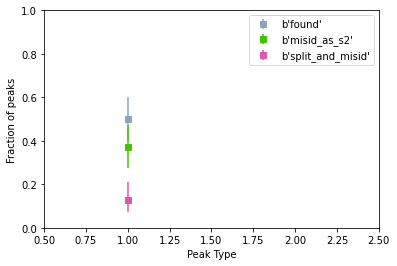

In [20]:
plot_peak_matching_histogram(truthmatched,'typeint',bins=[0.5,1.5,2.5])
plt.xlabel('Peak Type')
plt.show()

	16.84% b'found'
	0.67% b'merged'
	9.43% b'merged_to_s1'
	12.46% b'misid_as_s1'
	60.61% b'missed'


Text(0.5, 0, 'Peak Type')

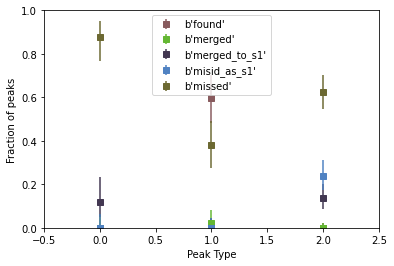

In [21]:
plot_peak_matching_histogram(datamatched,'typeint',bins= [-0.5,0.5,1.5,2.5])
plt.xlabel('Peak Type')

	50.00% b'found'
	37.00% b'misid_as_s2'
	13.00% b'split_and_misid'


Text(0.5, 0, 'Depth')

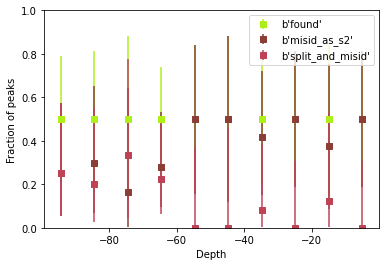

In [22]:
plot_peak_matching_histogram(truthmatched,'z')
plt.xlabel('Depth')

	16.84% b'found'
	0.67% b'merged'
	9.43% b'merged_to_s1'
	12.46% b'misid_as_s1'
	60.61% b'missed'


Text(0.5, 0, 'Area Fraction Top')

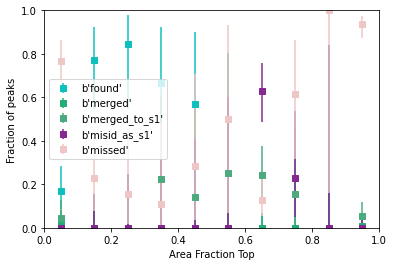

In [23]:
plot_peak_matching_histogram(datamatched,'area_fraction_top')
plt.xlabel('Area Fraction Top')